In [1]:
import math
import random
import copy
from matplotlib import pyplot as plt
import numpy as np

class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        class DroneVisit:
            def __init__(self,visitedNode,takeOffPoint):
                self.visitedNode = visitedNode
                self.recoveryPoint = -1
                self.takeOffPoint = takeOffPoint
                self.distance = None
                
            def __str__(self):
                return str(self.visitedNode)
            
            def __repr__(self):
                return "<DroneVisit tp:%d vn:%d rn:%d>" % (self.takeOffPoint, self.visitedNode,self.recoveryPoint)
            
        def __init__(self, alpha, beta, num_nodes, edges,droneVisitPheromone,nodeIsTruckPheromone,speedRaport):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.truckTour = None
            self.droneTour = None
            self.visitedNodes = [0]
            self.distance = 0.0
            self.droneVisitPheromone = droneVisitPheromone
            self.nodeIsTruckPheromone = nodeIsTruckPheromone
            self.speedRaport = speedRaport

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.visitedNodes]
            heuristic_total = 0.0
#             print(unvisited_nodes)
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.truckTour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.truckTour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.truckTour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.truckTour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.truckTour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node
                
        def isDroneVisit(self,nextNode):
            if(len(self.droneTour)>=len(self.truckTour)-1 or (len(self.droneTour)>0 and self.droneTour[-1].recoveryPoint == -1)):
                return False
#             print(nextNode,self.truckTour[-1])
#             print(self.truckTour)
#             print(self.droneTour)
            heuristic_total = self.edges[self.truckTour[-1]][nextNode].weight + self.edges[self.truckTour[-1]][nextNode].weight/self.speedRaport
            truckSelection = pow(self.nodeIsTruckPheromone[nextNode], self.alpha) * \
                                  pow((heuristic_total / self.edges[self.truckTour[-1]][nextNode].weight), self.beta);
            droneSelection = pow(self.droneVisitPheromone[nextNode], self.alpha) * \
                                  pow((heuristic_total / (self.edges[self.truckTour[-1]][nextNode].weight/self.speedRaport)), self.beta)
            wheel_position = 0.0;
            random_value = random.uniform(0.0,truckSelection+droneSelection);
            if(random_value>truckSelection):
                return True
            else:
                return False

        def find_tour(self):
            self.truckTour = [0]
            firstRandomCity = random.randint(1,self.num_nodes-1)
            self.truckTour.append(firstRandomCity)
            random.randint(0,9)
            self.droneTour = []
            self.visitedNodes = [0,firstRandomCity]
            while len(self.truckTour) + len(self.droneTour) < self.num_nodes:
                nextNode = self._select_node()
                self.visitedNodes.append(nextNode)
                if(self.isDroneVisit(nextNode)):
                    self.droneTour.append(self.DroneVisit(nextNode,self.truckTour[-1]))
                else:
                    if(len(self.droneTour)>0 and self.droneTour[-1].recoveryPoint == -1):
                        self.droneTour[-1].recoveryPoint = nextNode
                    self.truckTour.append(nextNode)
            return [self.truckTour,self.droneTour]

        def getTruckDistance(self):
            truckDistance = 0.0
            for i in range(len(self.truckTour)-1):
                truckDistance += self.edges[self.truckTour[i]][self.truckTour[(i + 1) % self.num_nodes]].weight
            return truckDistance
        
#         def calculateDronePoints(self):
#             for i in range(len(self.droneTour)):
#                 minDistance = [float('Inf'),float('Inf')]
#                 nodes = [-1,-1]
#                 poz = [-1,-1]
#                 for j in range(len(self.truckTour)):
#                     if(self.edges[self.truckTour[j]][self.droneTour[i].visitedNode].weight<minDistance[0]):
#                         nodes[1] = nodes[0]
#                         minDistance[1] = minDistance[0]
#                         poz[1] = poz[0]
#                         nodes[0] = self.truckTour[j]
#                         minDistance[0] = self.edges[self.truckTour[j]][self.droneTour[i].visitedNode].weight
#                         poz[0] = j
#                     elif self.edges[self.truckTour[j]][self.droneTour[i].visitedNode].weight<minDistance[1]:
#                         nodes[1] = self.truckTour[j]
#                         minDistance[1] = self.edges[self.truckTour[j]][self.droneTour[i].visitedNode].weight
#                         poz [1] = j
#                 if(poz[0]<poz[1]):
#                     self.droneTour[i].takeOffPoint = nodes[0]
#                     self.droneTour[i].recoveryPoint = nodes[1]
#                 else:
#                     self.droneTour[i].takeOffPoint = nodes[0]
#                     self.droneTour[i].recoveryPoint = nodes[1]
#                 self.droneTour[i].distance = self.edges[self.droneTour[i].takeOffPoint][self.droneTour[i].visitedNode].weight/self.speedRaport + \
#                                     self.edges[self.droneTour[i].visitedNode][self.droneTour[i].recoveryPoint].weight
        def calculateDronePoints(self):
            if(len(self.droneTour)>0 and self.droneTour[-1].recoveryPoint == -1):
                self.droneTour[-1].recoveryPoint = self.truckTour[0]
            
            for i in range(len(self.droneTour)):
#                 for j in range(len(self.truckTour)):
#                     if(self.droneTour[i].visitedNode == self.truckTour[j])
#                         timpTruck = self.edges[self.truckTour]
#                         costDrona = self.edges[]
#                 minDistance = [float('Inf'),float('Inf')]
#                 nodes = [-1,-1]
#                 poz = [-1,-1]
#                 for j in range(len(self.truckTour)):
#                     if(self.edges[self.truckTour[j]][self.droneTour[i].visitedNode].weight<minDistance[0]):
#                         nodes[1] = nodes[0]
#                         minDistance[1] = minDistance[0]
#                         poz[1] = poz[0]
#                         nodes[0] = self.truckTour[j]
#                         minDistance[0] = self.edges[self.truckTour[j]][self.droneTour[i].visitedNode].weight
#                         poz[0] = j
#                     elif self.edges[self.truckTour[j]][self.droneTour[i].visitedNode].weight<minDistance[1]:
#                         nodes[1] = self.truckTour[j]
#                         minDistance[1] = self.edges[self.truckTour[j]][self.droneTour[i].visitedNode].weight
#                         poz [1] = j
#                 if(poz[0]<poz[1]):
#                     self.droneTour[i].takeOffPoint = nodes[0]
#                     self.droneTour[i].recoveryPoint = nodes[1]
#                 else:
#                     self.droneTour[i].takeOffPoint = nodes[0]
#                     self.droneTour[i].recoveryPoint = nodes[1]
#                 print(repr(self.droneTour[i]))
#                 print(self.truckTour)
#                 print(self.droneTour)
                self.droneTour[i].distance = self.edges[self.droneTour[i].takeOffPoint][self.droneTour[i].visitedNode].weight/self.speedRaport + \
                                    self.edges[self.droneTour[i].visitedNode][self.droneTour[i].recoveryPoint].weight/self.speedRaport      
    
        def get_distance(self):
            self.distance = 0.0 
            self.calculateDronePoints()
            droneTourPoz = 0;
            for i in range(len(self.truckTour)):
#                 print(i)
#                 print(droneTourPoz)
#                 print(len(self.truckTour))
#                 print(len(self.droneTour))
                if(len(self.droneTour)>droneTourPoz and self.truckTour[(i+1)% len(self.truckTour)] == self.droneTour[droneTourPoz]):
                    truckDistance = self.edges[self.truckTour[i]][self.truckTour[(i + 1) % len(self.truckTour)]].weight
                    self.distance += max(truckDistance, self.droneTour[droneTourPoz].distance)
                    droneTourPoz += 1
                else:
                    self.distance += self.edges[self.truckTour[i]][self.truckTour[(i + 1) % len(self.truckTour)]].weight
            return self.distance

    def __init__(self, mode='ACS', colony_size=100, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.2, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=2, nodes=None, labels=None,speedRaport=2):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(self.num_nodes)
        self.speedRaport = speedRaport
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.droneVisitPheromone = []
        self.nodeIsTruckPheromone = []
        for i in range(self.num_nodes):
            self.droneVisitPheromone.append(initial_pheromone)
            self.nodeIsTruckPheromone.append(initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges, self.droneVisitPheromone, self.nodeIsTruckPheromone,self.speedRaport) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(len(tour[0])):
            self.nodeIsTruckPheromone[tour[0][i]] = weight * pheromone_to_add
            self.edges[tour[0][i]][tour[0][(i + 1) % len(tour[0])]].pheromone += weight * pheromone_to_add
        for i in range(len(tour[1])):
            self.droneVisitPheromone[tour[1][i].visitedNode] = weight * pheromone_to_add
#         print(self.droneVisitPheromone)
#         print(tour[0])
#         print(tour[1])

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = [ant.truckTour,ant.droneTour]
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                self.droneVisitPheromone[i] *= (1.0 - self.rho)
                self.nodeIsTruckPheromone[i] *= (1.0-self.rho)

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = [ant.truckTour,ant.droneTour]
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _max_min(self):
        for step in range(self.steps):
            iteration_best_tour = None
            iteration_best_distance = float("inf")
            for ant in self.ants:
                ant.find_tour()
                if ant.get_distance() < iteration_best_distance:
                    iteration_best_tour = ant.truckTour
                    iteration_best_distance = ant.distance
            if float(step + 1) / float(self.steps) <= 0.75:
                self._add_pheromone(iteration_best_tour, iteration_best_distance)
                max_pheromone = self.pheromone_deposit_weight / iteration_best_distance
            else:
                if iteration_best_distance < self.global_best_distance:
                    self.global_best_tour = iteration_best_tour
                    self.global_best_distance = iteration_best_distance
                self._add_pheromone(self.global_best_tour, self.global_best_distance)
                max_pheromone = self.pheromone_deposit_weight / self.global_best_distance
            min_pheromone = max_pheromone * self.min_scaling_factor
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    if self.edges[i][j].pheromone > max_pheromone:
                        self.edges[i][j].pheromone = max_pheromone
                    elif self.edges[i][j].pheromone < min_pheromone:
                        self.edges[i][j].pheromone = min_pheromone

    def run(self):
#         print('Started : {0}'.format(self.mode))
        if self.mode == 'ACS':
            self._acs()
        elif self.mode == 'Elitist':
            self._elitist()
        else:
            self._max_min()
#         print('Ended : {0}'.format(self.mode))
#         print('Sequence : <- {0} ->'.format(' - '.join(str(self.labels[i]) for i in self.global_best_tour)))
        print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2)))

    def plot(self, line_width=1, point_radius=math.sqrt(2.0), annotation_size=8, dpi=120, save=True, name=None):
        
        print(self.global_best_tour[0])
        print(self.global_best_tour[1])
        
        
        ax = [];
        ay = [];
        
        fig, plot = plt.subplots(nrows=1, ncols=1, constrained_layout=False)
        
        for i in range(self.num_nodes):
            ax.append(self.nodes[i][0])
            ay.append(self.nodes[i][1])
            

        plot.scatter(ax, ay, s=15)
        
        x = [self.nodes[i][0] for i in self.global_best_tour[0]]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour[0]]
        y.append(y[0])
        
            
        dx = [];
        dy = [];
        
        
        for i in self.global_best_tour[1]:
            dx = [];
            dy = [];
            dx.append(self.nodes[i.takeOffPoint][0])
            dx.append(self.nodes[i.visitedNode][0])
            dx.append(self.nodes[i.recoveryPoint][0])
            dy.append(self.nodes[i.takeOffPoint][1])
            dy.append(self.nodes[i.visitedNode][1])
            dy.append(self.nodes[i.recoveryPoint][1])
            plot.plot(dx,dy, linewidth=2, color="g")


        
        
        
        for i in range(self.num_nodes):
            plot.annotate(self.labels[i], self.nodes[i], size=annotation_size)

#         plot.title(self.mode)
        
        
        fig.set_figheight(5)
        fig.set_figwidth(7.5)
        
        plot.plot(x, y, linewidth=2, color="b")
        
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            fig.savefig(name, dpi=dpi)
        #plot.show()
        #plot.gcf().clear()


In [2]:
import tsplib95
def getCities(filename):
    problem = tsplib95.load_problem('Dataset' + '/'+ filename + '.tsp')
    cities = []
    for i in range(1, problem.dimension + 1):
        cities.append(problem.get_display(i))
    return cities

In [8]:
_colony_size = 50
_steps = 1000
# _nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 15)]
_nodes = getCities('eil51')
_nodes10 = _nodes[:10]
_nodes30 = _nodes[:30]

Total distance travelled to complete the tour : 96.2

Total distance travelled to complete the tour : 96.05

Total distance travelled to complete the tour : 96.05

Total distance travelled to complete the tour : 96.05

Total distance travelled to complete the tour : 96.2

Total distance travelled to complete the tour : 96.05

Total distance travelled to complete the tour : 96.2

Total distance travelled to complete the tour : 96.05

Total distance travelled to complete the tour : 96.05

Total distance travelled to complete the tour : 96.05

[96.20221208478013, 96.05254449168939, 96.05254449168936, 96.05254449168936, 96.20221208478013, 96.05254449168939, 96.20221208478013, 96.05254449168939, 96.05254449168939, 96.05254449168939]
96.1
[0, 5, 6, 7, 2, 1]
[<DroneVisit tp:5 vn:9 rn:6>, <DroneVisit tp:6 vn:3 rn:7>, <DroneVisit tp:2 vn:8 rn:1>, <DroneVisit tp:1 vn:4 rn:0>]
96.05254449168936


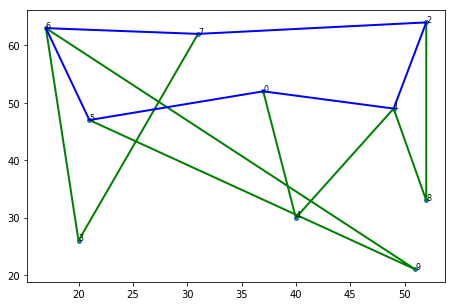

In [9]:
medie = []
bestDistance = float("inf")
bestTour = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=_nodes10)
for i in range(10):
    acs = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=_nodes10)
    acs.run()
    medie.append(acs.global_best_distance)
    if(acs.global_best_distance < bestDistance):
        bestTour = copy.deepcopy(acs)
        bestDistance = acs.global_best_distance
    
print(medie)
print(round(sum(medie)/len(medie),2))
bestTour.plot()
print(bestDistance)
    
# round(self.global_best_distance, 2)

Total distance travelled to complete the tour : 177.97

Total distance travelled to complete the tour : 184.2

Total distance travelled to complete the tour : 184.31

Total distance travelled to complete the tour : 186.15

Total distance travelled to complete the tour : 183.16

Total distance travelled to complete the tour : 183.53

Total distance travelled to complete the tour : 179.95

Total distance travelled to complete the tour : 188.47

Total distance travelled to complete the tour : 184.86

Total distance travelled to complete the tour : 184.49

183.71
[0, 7, 6, 22, 23, 5, 17, 3, 16, 14, 9, 29, 15, 28, 19, 21]
[<DroneVisit tp:7 vn:25 rn:6>, <DroneVisit tp:22 vn:13 rn:23>, <DroneVisit tp:23 vn:24 rn:5>, <DroneVisit tp:5 vn:26 rn:17>, <DroneVisit tp:17 vn:12 rn:3>, <DroneVisit tp:3 vn:11 rn:16>, <DroneVisit tp:16 vn:18 rn:14>, <DroneVisit tp:14 vn:4 rn:9>, <DroneVisit tp:9 vn:8 rn:29>, <DroneVisit tp:29 vn:20 rn:15>, <DroneVisit tp:15 vn:10 rn:28>, <DroneVisit tp:28 vn:1 rn:19>, <

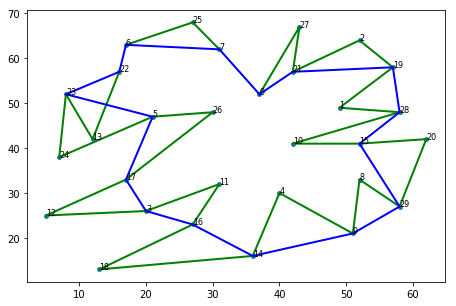

In [10]:
medie = []
bestDistance = float("inf")
for i in range(10):
    acs = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=_nodes30)
    acs.run()
    medie.append(acs.global_best_distance)
    if(acs.global_best_distance < bestDistance):
        bestTour = copy.deepcopy(acs)
        bestDistance = acs.global_best_distance
print(round(sum(medie)/len(medie),2))
bestTour.plot()
print(bestDistance)
print(medie)

Total distance travelled to complete the tour : 299.88

Total distance travelled to complete the tour : 291.23

Total distance travelled to complete the tour : 267.29

Total distance travelled to complete the tour : 294.27

Total distance travelled to complete the tour : 288.18

Total distance travelled to complete the tour : 288.54

Total distance travelled to complete the tour : 287.97

Total distance travelled to complete the tour : 287.96

Total distance travelled to complete the tour : 277.96

Total distance travelled to complete the tour : 281.14

286.44
[0, 31, 45, 11, 46, 3, 40, 18, 41, 14, 36, 38, 9, 29, 33, 20, 28, 19, 34, 27, 30, 25, 6, 22, 23, 5, 26]
[<DroneVisit tp:31 vn:10 rn:45>, <DroneVisit tp:45 vn:50 rn:11>, <DroneVisit tp:11 vn:4 rn:46>, <DroneVisit tp:46 vn:16 rn:3>, <DroneVisit tp:3 vn:17 rn:40>, <DroneVisit tp:40 vn:12 rn:18>, <DroneVisit tp:18 vn:39 rn:41>, <DroneVisit tp:41 vn:43 rn:14>, <DroneVisit tp:14 vn:44 rn:36>, <DroneVisit tp:36 vn:32 rn:38>, <DroneVisit

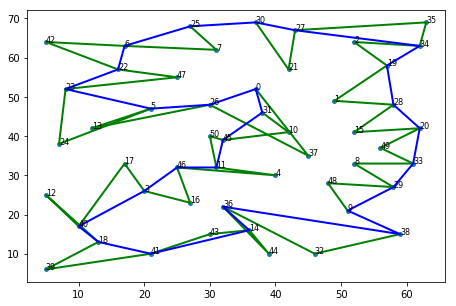

In [11]:
medie = []
bestDistance = float("inf")
bestTour = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=_nodes30)
for i in range(10):
    acs = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    acs.run()
    medie.append(acs.global_best_distance)
    if(acs.global_best_distance < bestDistance):
        bestTour = copy.deepcopy(acs)
        bestDistance = acs.global_best_distance
print(round(sum(medie)/len(medie),2))
bestTour.plot()
print(bestDistance)
print(medie)